In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_core.tools import tool
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchResults 

@tool
def get_web_search(query: str, search_period: str='w') -> str:
    """
    웹 검색을 수행하는 함수.

    Args:
        query (str): 검색어
        search_period (str): 검색 기간 (e.g., "w" for past week (default), "m" for past month, "y" for past year, "d" for past day)

    Returns:
        str: 검색 결과
    """
    wrapper = DuckDuckGoSearchAPIWrapper(
        region="kr-kr",
        time=search_period
    )

    print('\n----- WEB SEARCH -----')
    print(query)
    print(search_period)

    search = DuckDuckGoSearchResults(
        api_wrapper=wrapper,
        source="news",
        results_separator=';\n'
    )

    searched = search.invoke(query)
    
    for i, result in enumerate(searched.split(';\n')):
        print(f'{i+1}. {result}')
    
    return searched

In [3]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model="google_genai:gemini-2.5-flash",
    tools=[get_web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

In [4]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [5]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent = create_react_agent(
    model="google_genai:gemini-2.5-flash",
    tools=[add, multiply, divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent",
)

In [6]:
from typing import Annotated
from langchain_core.tools import tool
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command
from langgraph.types import Send


def create_task_description_handoff_tool(
    *, agent_name: str, description: str | None = None
):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        # this is populated by the supervisor LLM
        task_description: Annotated[
            str,
            "Description of what the next agent should do, including all of the relevant context.",
        ],
        # these parameters are ignored by the LLM
        state: Annotated[MessagesState, InjectedState],
    ) -> Command:
        task_description_message = {"role": "user", "content": task_description}
        agent_input = {**state, "messages": [task_description_message]}
        return Command(
            goto=[Send(agent_name, agent_input)],
            graph=Command.PARENT,
        )

    return handoff_tool


assign_to_research_agent_with_description = create_task_description_handoff_tool(
    agent_name="research_agent",
    description="Assign task to a researcher agent.",
)

assign_to_math_agent_with_description = create_task_description_handoff_tool(
    agent_name="math_agent",
    description="Assign task to a math agent.",
)


In [7]:
supervisor_agent_with_description = create_react_agent(
    model="google_genai:gemini-2.5-flash",
    tools=[
        assign_to_research_agent_with_description,
        assign_to_math_agent_with_description,
    ],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this assistant\n"
        "- a math agent. Assign math-related tasks to this assistant\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="supervisor",
)


In [8]:
supervisor_with_description = (
    StateGraph(MessagesState)
    .add_node(
        supervisor_agent_with_description, destinations=("research_agent", "math_agent")
    )
    .add_node(research_agent)
    .add_node(math_agent)
    .add_edge(START, "supervisor")
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .compile()
)

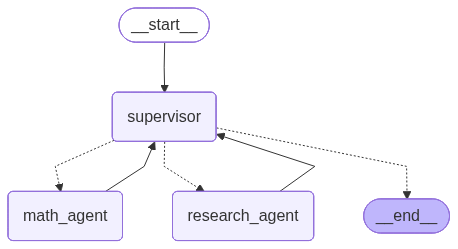

In [9]:
from IPython.display import display, Image

display(Image(supervisor_with_description.get_graph().draw_mermaid_png()))

In [ ]:
for chunk in supervisor_with_description.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "현재 박스오피스 1위 영화가 무엇이며 관람객 수를 보고서로 작성해줘?",
            }
        ]
    },
    subgraphs=True,
):
    pretty_print_messages(chunk, last_message=True)

Update from subgraph supervisor:


	Update from node agent:


	================================== Ai Message ==================================
	Name: supervisor
	Tool Calls:
	  transfer_to_research_agent (658c9456-fa7c-44a4-9d73-65ad78c8d37a)
	 Call ID: 658c9456-fa7c-44a4-9d73-65ad78c8d37a
	  Args:
	    task_description: 현재 박스오피스 1위 영화가 무엇이며, 해당 영화의 관람객 수를 조사하여 보고서 형식으로 작성해 주세요.



----- WEB SEARCH -----
현재 박스오피스 1위 영화
d
Update from subgraph research_agent:


	Update from node agent:


	================================== Ai Message ==================================
	Name: research_agent
	Tool Calls:
	  get_web_search (72b2dc1b-8770-4d26-a9e8-3587823414b2)
	 Call ID: 72b2dc1b-8770-4d26-a9e8-3587823414b2
	  Args:
	    query: 현재 박스오피스 1위 영화
	    search_period: d


1. snippet: [뉴스컬처 노규민 기자] 박찬욱 감독 영화 '어쩔수가없다'가 압도적인 흥행세를 과시하며 100만 돌파를 향하고 있다.28일 영화진흥위원회 영화관입장권 통합전산망에 따르면 '어쩔수가없다'는 지난 27일 하루 24만 2011명을 동원하며 4일 연속 박스오피스 1 위를 지켰다. 누적 관객수는 83만 3407명. '어쩔 ..., title: [Nc박스오피스] '어쩔수가없다' 土 24만, 

In [13]:
result = supervisor_with_description.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "현재 박스오피스 1위 영화가 무엇이며 관람객 수를 보고서로 작성해줘?",
            }
        ]
    },
    subgraphs=True,
)


----- WEB SEARCH -----
현재 박스오피스 1위 영화
w
1. snippet: 본 자료는 영화진흥위원회 영화관입장권통합전산망의 주간/주말 박스오피스 집계 자료를 출처로 하고 있으며, 관객 수와 매출액은 주마다 갱신된 총량을 기준으로 한다., title: 틀:대한민국 주간·주말 박스오피스 1 위 영화 /2024년 - 나무위키, link: https://namu.wiki/w/틀:대한민국+주간·주말+박스오피스+1위+영화/2024년
2. snippet: ‘모아나 2’는 현재 극장에서 상영 중인 ‘위키드’, ‘히든페이스’, ‘글래디에이터 2’ 등 앞서 개봉한 쟁쟁한 대작들과 함께 박스오피스 경쟁을 벌이고 있다. 곧 있으면 개봉 예정인 한국 영화 ‘1승’, ‘소방관’, ‘대가족’과도 치열한 경합을 예고하고 있다. 물론 디즈니의 탄탄한 팬층을 바탕으로 흥행을..., title: “개봉 당일 터졌다…” 대작 ‘위키드’ 꺾고 박스오피스 1 위 흥행 독주 중인..., link: https://www.wikitree.co.kr/articles/1004211
3. snippet: 영화 ‘하얼빈’은 지난 24일 개봉 이후 누적 관객 수가 238만 5천여 명을 기록했습니다. 주말 박스오피스 2위는 지난 사흘간 23만 3천여 명을 동원한 곽경택 감독의 영화 ‘소방관’이 차지했습니다., title: 영화 ‘하얼빈’ 200만 관객 돌파 ‘ 박스오피스 1 위 ’ | KBS 뉴스, link: https://news.kbs.co.kr/news/pc/view/view.do?ncd=8140966
4. snippet: [KtN 신미희기자] 폭우도 막지 못한 박찬욱의 신작 흡인력, 는 감독의 필모그래피를 넘어 한국영화 흥행 지형을 새롭게 써 내려가고 있다.박찬욱 감독의 12번째 장편영화 가 개봉 첫날 33만1518명의 관객을 동원하며 박스오피스 1 위에 올랐다., title: ' 박스오피스 1 위 ' 추석 황금연휴까지... - KtN (K trendy NEWS), link: https:

Gemini produced an empty response. Continuing with empty message
Feedback: 


In [17]:
import pprint
pprint.pprint(result["messages"])

[HumanMessage(content='현재 박스오피스 1위 영화가 무엇이며 관람객 수를 보고서로 작성해줘?', additional_kwargs={}, response_metadata={}, id='167d165d-f9fe-493c-9170-82464ad1bf3c'),
 HumanMessage(content='현재 박스오피스 1위 영화가 무엇인지, 그리고 해당 영화의 관람객 수가 어떻게 되는지 조사하여 보고서 형식으로 작성해주세요.', additional_kwargs={}, response_metadata={}, id='7dd03399-a016-4c38-b7cc-c63d6d0c04d6'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_web_search', 'arguments': '{"query": "\\ud604\\uc7ac \\ubc15\\uc2a4\\uc624\\ud53c\\uc2a4 1\\uc704 \\uc601\\ud654"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, name='research_agent', id='run--5dcc7f90-d227-4969-ab32-bab192fd6c1e-0', tool_calls=[{'name': 'get_web_search', 'args': {'query': '현재 박스오피스 1위 영화'}, 'id': '053d0b7e-8926-4ccc-9375-5af06b247b2b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 221, 'output_tokens': 114, 'total_tokens': 335, 'input_token